In [1]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.random import set_seed as SEED
from tensorflow.keras import Sequential as SQ
from tensorflow.keras.losses import CategoricalCrossentropy as CCE
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import files

files.upload()

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [01:21<00:00, 21.5MB/s]
100% 1.76G/1.76G [01:21<00:00, 23.1MB/s]


In [5]:
import zipfile

zipref = zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip', mode = 'r')
zipref.extractall()
zipref.close()

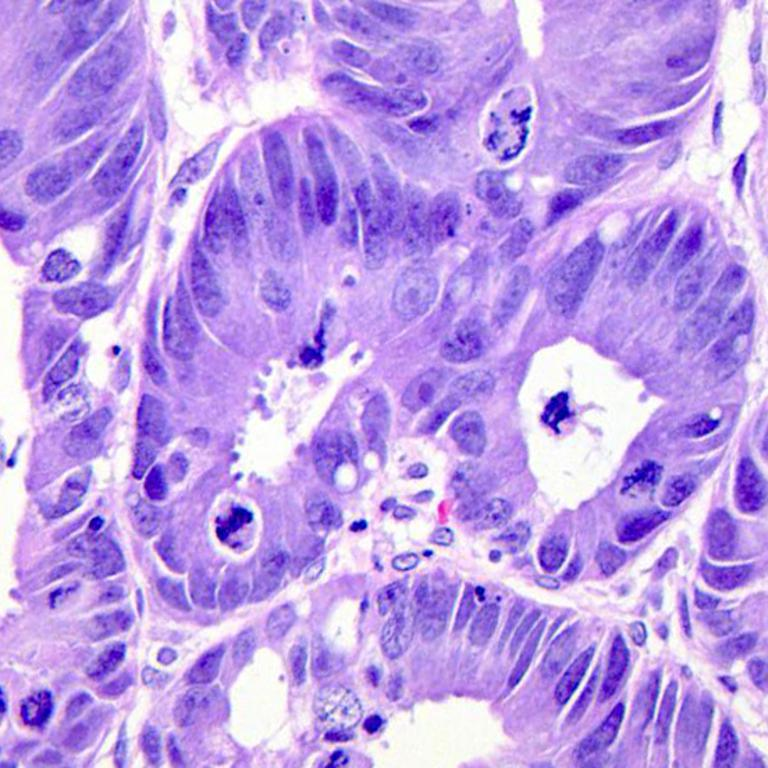

In [ ]:
tf.keras.preprocessing.image.load_img('/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1054.jpeg')

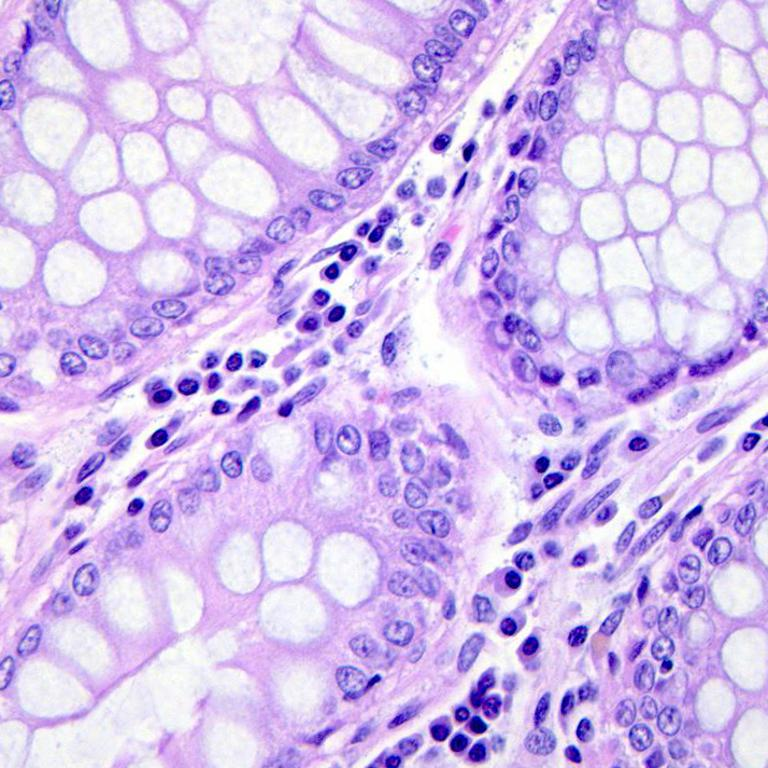

In [ ]:
tf.keras.preprocessing.image.load_img('/content/lung_colon_image_set/colon_image_sets/colon_n/colonn1006.jpeg')

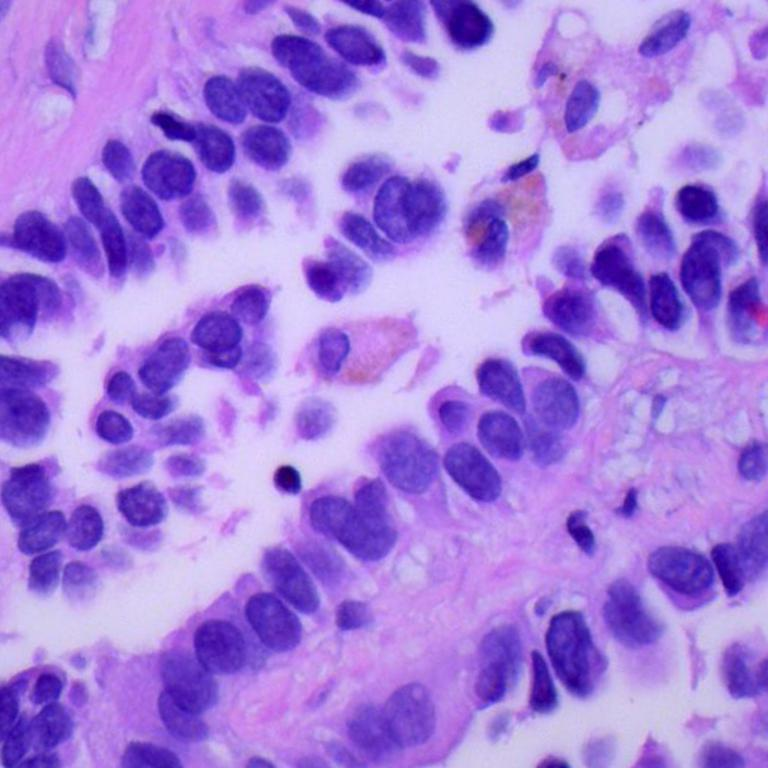

In [ ]:
tf.keras.preprocessing.image.load_img('/content/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1006.jpeg')

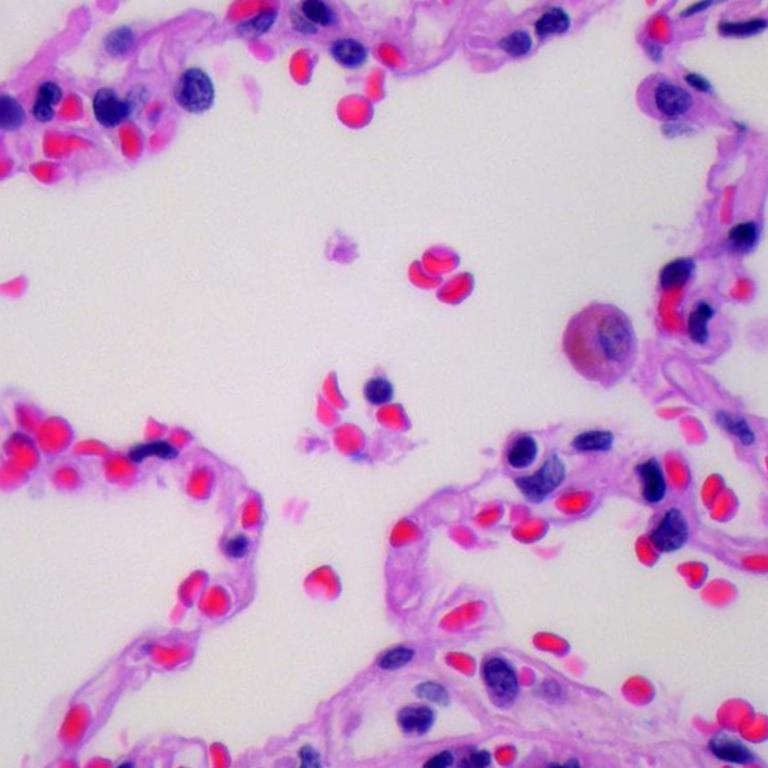

In [ ]:
tf.keras.preprocessing.image.load_img('/content/lung_colon_image_set/lung_image_sets/lung_n/lungn1004.jpeg')

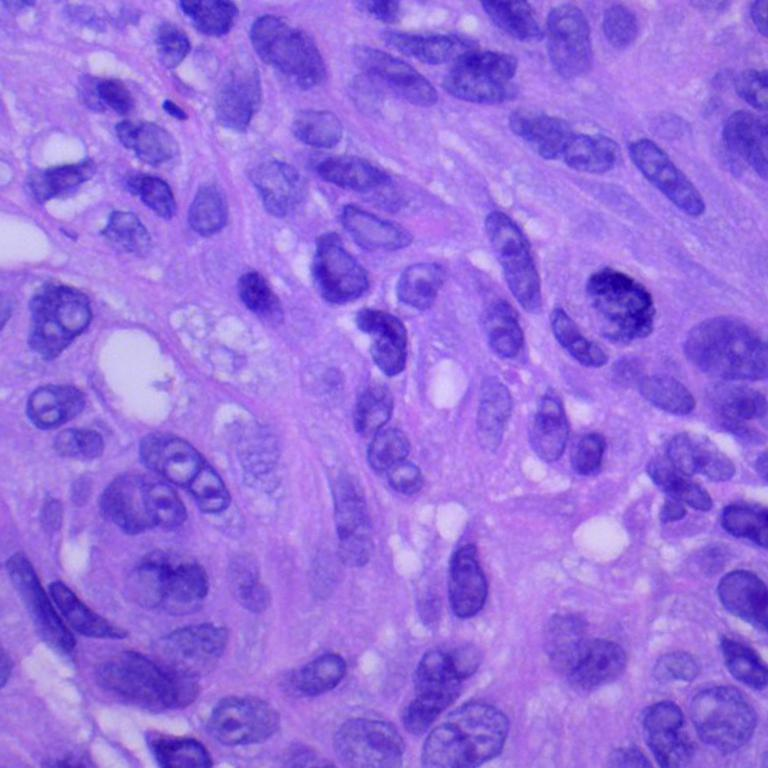

In [ ]:
tf.keras.preprocessing.image.load_img('/content/lung_colon_image_set/lung_image_sets/lung_scc/lungscc101.jpeg')

In [6]:
import os

for dirpath, dirnames, filenames in os.walk('/content/lung_colon_image_set'):
  if len(filenames) > 0:
    print(f'There are {len(filenames)} files in {os.path.basename(dirpath)}')

There are 5000 files in lung_scc
There are 5000 files in lung_aca
There are 5000 files in lung_n
There are 5000 files in colon_aca
There are 5000 files in colon_n


In [7]:
import shutil
import random

root_path = '/content/lung_colon_image_set'
train_folder = '/content/train_dir'
test_folder = '/content/test_dir'

if os.path.exists(train_folder):
  shutil.rmtree(train_folder)
if os.path.exists(test_folder):
  shutil.rmtree(test_folder)

os.makedirs(train_folder, exist_ok = False)
os.makedirs(test_folder, exist_ok = False)

subdirectories = [i for i in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, i))]

for subdir in subdirectories:
  subdir_path = os.path.join(root_path, subdir)
  files = [f for f in os.listdir(subdir_path) if os.path.isdir(os.path.join(subdir_path, f))]

  for file in files:
    path = os.path.join(subdir_path, file)

    train_label_folder = os.path.join(train_folder, os.path.basename(path))
    os.makedirs(train_label_folder, exist_ok = True)

    test_label_folder = os.path.join(test_folder, os.path.basename(path))
    os.makedirs(test_label_folder, exist_ok = True)

    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    train_data = files[:int(0.7 * len(files))]
    test_data = files[int(0.7 * len(files)):]

    for file in train_data:
      src_file = os.path.join(path, file)
      dest_file = os.path.join(train_label_folder, file)
      shutil.copy(src_file, dest_file)

    for file in test_data:
      src_file = os.path.join(path, file)
      dest_file = os.path.join(test_label_folder, file)
      shutil.copy(src_file, dest_file)

print('Completed successfully!')

Completed successfully!


In [ ]:
for dirpath, dirnames, filenames in os.walk('/content/train_dir'):
  if len(filenames) > 0:
    print(f'There are {len(filenames)} files in {os.path.basename(dirpath)}')

There are 3500 files in colon_aca
There are 3500 files in lung_aca
There are 3500 files in colon_n
There are 3500 files in lung_n
There are 3500 files in lung_scc


In [ ]:
for dirpath, dirnames, filenames in os.walk('/content/test_dir'):
  if len(filenames) > 0:
    print(f'There are {len(filenames)} files in {os.path.basename(dirpath)}')

There are 1500 files in colon_aca
There are 1500 files in lung_aca
There are 1500 files in colon_n
There are 1500 files in lung_n
There are 1500 files in lung_scc


In [8]:
train_gen = ImageDataGenerator(rescale = 1/255.)
test_gen = ImageDataGenerator(rescale = 1/255.)

train_data = train_gen.flow_from_directory('/content/train_dir',
                                           target_size = (128, 128),
                                           batch_size = 32,
                                           shuffle = True,
                                           class_mode = 'categorical')

test_data = test_gen.flow_from_directory('/content/test_dir',
                                          target_size = (128, 128),
                                          batch_size = 32,
                                          shuffle = True,
                                          class_mode = 'categorical')

Found 17500 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.


In [ ]:
train_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [ ]:
train_data.class_indices

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}

In [ ]:
test_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [ ]:
test_data.class_indices

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}

In [9]:
model = SQ()
model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 input_shape = (128, 128, 3),
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = 1))
model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = 1))
model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = 1))
model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = 1))
model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = 1))
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))

In [10]:
model.compile(loss = CCE(),
              optimizer = Adam(),
              metrics = 'accuracy')

In [11]:
history = model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = len(test_data))

Epoch 1/5
547/547 [==============================] - 121s 206ms/step - loss: 0.6353 - accuracy: 0.7575 - val_loss: 0.3818 - val_accuracy: 0.8477
Epoch 2/5
547/547 [==============================] - 111s 202ms/step - loss: 0.2931 - accuracy: 0.8843 - val_loss: 0.3541 - val_accuracy: 0.8569
Epoch 3/5
547/547 [==============================] - 111s 202ms/step - loss: 0.1687 - accuracy: 0.9350 - val_loss: 0.3631 - val_accuracy: 0.8607
Epoch 4/5
547/547 [==============================] - 110s 200ms/step - loss: 0.0981 - accuracy: 0.9631 - val_loss: 0.2697 - val_accuracy: 0.9059
Epoch 5/5
547/547 [==============================] - 106s 194ms/step - loss: 0.0493 - accuracy: 0.9833 - val_loss: 0.3702 - val_accuracy: 0.9215


<Axes: >

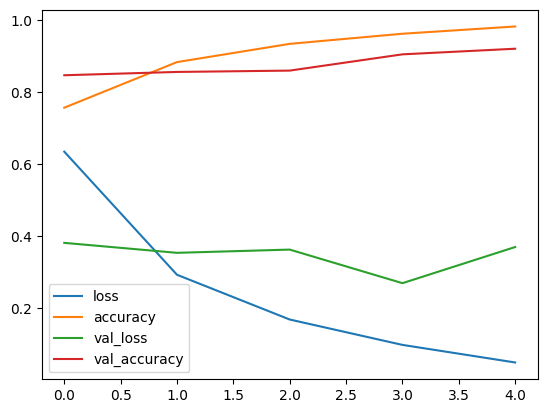

In [12]:
import pandas as pd

pd.DataFrame(history.history).plot()

In [13]:
train_dir = '/content/train_dir'
test_dir = '/content/test_dir'

In [14]:
model.evaluate(test_data)

235/235 [==============================] - 28s 119ms/step - loss: 0.3702 - accuracy: 0.9215


[0.370240718126297, 0.9214666485786438]

In [42]:
import random

def image_predictions(n = 1):
  class_dict = train_data.class_indices
  class_n = {index: classes for classes, index in class_dict.items()}
  images = []
  labels = []
  for batch_num in range(len(test_data)):
    batch_images, batch_labels = test_data.next()
    images.extend(batch_images)
    labels.extend(batch_labels)

  images = np.array(images)
  lables = np.array(labels)
  random_sample = random.sample(range(0, len(images)-1), n)
  for i in random_sample:
    img = images[i]
    label = np.argmax(labels[i])
    img_reshaped = img.reshape(-1, 128, 128, 3)
    prediction = model.predict(img_reshaped)
    pred_label = np.argmax(prediction)
    img_display = (img * 255.).astype(np.uint8)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_display, (324, 324))
    cv2.putText(img_resized,
              'Predicted: ' + str(class_n[pred_label]),
              (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL,
              1,
              (0, 255, 0) if str(pred_label) == str(label) else (0, 0, 255),
              1)
    cv2.putText(img_resized,
              'Expected: ' + str(class_n[label]),
              (10, 50),
              cv2.FONT_HERSHEY_COMPLEX_SMALL,
              1,
              (0, 255, 0),
              1)
    cv2_imshow(img_resized)

1/1 [==============================] - 0s 18ms/step


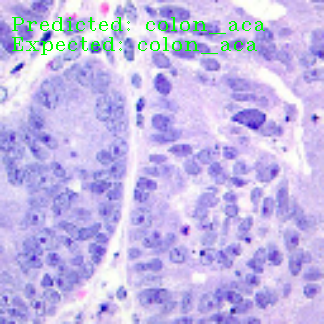

1/1 [==============================] - 0s 19ms/step


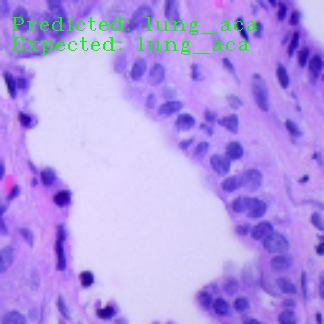

1/1 [==============================] - 0s 17ms/step


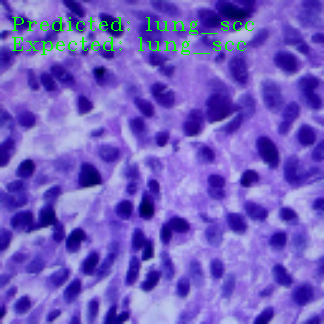

1/1 [==============================] - 0s 18ms/step


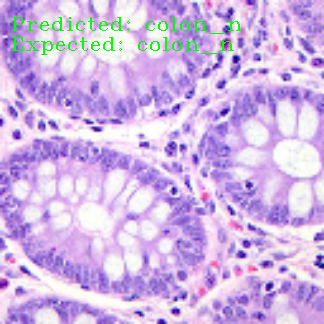

1/1 [==============================] - 0s 27ms/step


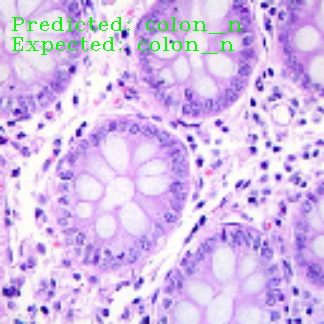

In [43]:
image_predictions(5)

Model displays a good accuracy!